In [ ]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA


In [ ]:

# Carga de datos
df = pd.read_csv('../data/digital_wallet_ltv_dataset.csv')
# Vista previa del dataframe
df.head()
# Información general del dataframe
df.info()


In [ ]:
# Exploración inicial de datos
# 1. Revisión de valores faltantes
print("Valores faltantes por columna:")
print(df.isnull().sum())

# 2. Ver duplicados
print("\nNúmero de registros duplicados:", df.duplicated().sum())

# 3. Descripción estadística de variables numéricas
display(df.describe())

# 4. Conteo de categorías en variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nDistribución de '{col}':")
    print(df[col].value_counts())


In [ ]:
# Detección de outliers en variables clave
cols = ['Total_Spent', 'Avg_Transaction_Value', 'LTV']
df[cols].boxplot(figsize=(10, 5))
plt.title('Boxplots de variables numéricas clave')
plt.show()


In [ ]:
# Histograma de distribución de LTV
df['LTV'].hist(bins=30)
plt.title('Distribución de LTV')
plt.xlabel('LTV')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Mapa de calor de la matriz de correlación

corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Matriz de correlación')
plt.show()


In [ ]:
# Preparación de datos para modelado
# Eliminar columnas no predictivas y evitar fugas de datos
df_model = df.drop(columns=['Customer_ID', 'Total_Spent'])

# Binning de la variable objetivo para clasificación
bins = [df_model['LTV'].min() - 1,
        df_model['LTV'].quantile(0.33),
        df_model['LTV'].quantile(0.66),
        df_model['LTV'].max() + 1]
labels = ['bajo', 'medio', 'alto']
df_model['LTV_cat'] = pd.cut(df_model['LTV'], bins=bins, labels=labels)

# Codificación de variables categóricas
df_encoded = pd.get_dummies(df_model, drop_first=True)

# Definición de features y target para regresión y clasificación
X_reg = df_model.select_dtypes(include='number').drop(columns=['LTV'])
y_reg = df_model['LTV']

 # Definir features para clasificación excluyendo la variable LTV y sus dummies
drop_cols = ['LTV'] + [col for col in df_encoded.columns if col.startswith('LTV_cat_')]
X_cls = df_encoded.drop(columns=drop_cols)
# Definir target para clasificación directamente desde df_model
y_cls = df_model['LTV_cat']

# División de conjuntos de entrenamiento y prueba
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, random_state=42)
X_cls_train, X_cls_test, y_cls_train, y_cls_test = train_test_split(
    X_cls, y_cls, stratify=y_cls, random_state=42)


In [ ]:
# Correlación de features con la variable objetivo LTV
corr_full = df_model.select_dtypes(include='number').corr()
print("Correlaciones de cada variable numérica con LTV:")
print(corr_full['LTV'].sort_values(ascending=False))


In [ ]:
# Entrenamiento y evaluación del modelo de Regresión Lineal
lr = LinearRegression()
lr.fit(X_reg_train, y_reg_train)
y_pred_reg = lr.predict(X_reg_test)

# Métricas de regresión
print("R² en conjunto de prueba:", r2_score(y_reg_test, y_pred_reg))

# Gráfico de Valores Reales vs Predichos
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test, y_pred_reg, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         'r--')
plt.xlabel("LTV Real")
plt.ylabel("LTV Predicho")
plt.title("Regresión Lineal: Real vs Predicho")
plt.show()


In [ ]:
# Entrenamiento y evaluación del modelo de Regresión Logística
log_clf = LogisticRegression(max_iter=1000)
log_clf.fit(X_cls_train, y_cls_train)
y_pred_cls = log_clf.predict(X_cls_test)

# Matriz de confusión y reporte
print("Reporte de clasificación:\n", classification_report(y_cls_test, y_pred_cls))
cm = confusion_matrix(y_cls_test, y_pred_cls)
print("Matriz de confusión:\n", cm)

# Curva ROC multiclase
y_probs = log_clf.predict_proba(X_cls_test)
roc_auc = roc_auc_score(pd.get_dummies(y_cls_test), y_probs, multi_class='ovo')
print("AUC multiclase:", roc_auc)


In [ ]:
# Mejora de Regresión Logística: escalado y balance de clases en pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Pipeline con escalador y LogisticRegression balanceada
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
)
pipe.fit(X_cls_train, y_cls_train)
y_pred_pipe = pipe.predict(X_cls_test)

# Métricas mejoradas
print("Reporte de clasificación mejorado:\n", classification_report(y_cls_test, y_pred_pipe))
cm_pipe = confusion_matrix(y_cls_test, y_pred_pipe)
print("Matriz de confusión mejorada:\n", cm_pipe)
y_probs_pipe = pipe.predict_proba(X_cls_test)
roc_auc_pipe = roc_auc_score(pd.get_dummies(y_cls_test), y_probs_pipe, multi_class='ovo')
print("AUC multiclase mejorado:", roc_auc_pipe)


In [ ]:
# Random Forest Regressor: comparación de R² y gráfica
from sklearn.ensemble import RandomForestRegressor

# Configurar y entrenar Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
rf_reg.fit(X_reg_train, y_reg_train)
y_pred_rf_reg = rf_reg.predict(X_reg_test)

# R² para Random Forest Regressor
print("R² Random Forest Regressor en prueba:", r2_score(y_reg_test, y_pred_rf_reg))

# Gráfico de valores reales vs predichos con Random Forest
plt.figure(figsize=(6,6))
plt.scatter(y_reg_test, y_pred_rf_reg, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         'r--')
plt.xlabel("LTV Real")
plt.ylabel("LTV Predicho (RF Regressor)")
plt.title("Random Forest Regressor: Real vs Predicho")
plt.show()


In [ ]:
# Diagnóstico de Random Forest Regressor: sobreajuste y importancias
# 1. R² en entrenamiento vs prueba
print("R² entrenamiento RF regressor:", rf_reg.score(X_reg_train, y_reg_train))
print("R² prueba RF regressor:",    rf_reg.score(X_reg_test,  y_reg_test))

# 2. Importancias de features
importances = pd.Series(rf_reg.feature_importances_, index=X_reg.columns).sort_values(ascending=False)
print("\nImportancias de características:\n", importances)


In [ ]:
# Validación cruzada y búsqueda de hiperparámetros para RF Regressor
from sklearn.model_selection import cross_val_score, GridSearchCV

# 1. Validación cruzada 5-fold para R²
scores = cross_val_score(rf_reg, X_reg, y_reg, cv=5, scoring='r2')
print("CV R² RF regressor (5 folds):", scores)
print("Media CV R²:", scores.mean())

# 2. GridSearchCV para ajustar n_estimators y max_depth
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, None]
}
gs = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid, cv=3, scoring='r2', n_jobs=-1
)
gs.fit(X_reg, y_reg)
print("Mejores parámetros RF Regressor:", gs.best_params_)
print("Mejor CV R²:", gs.best_score_)

In [ ]:
# Clasificación con Random Forest
from sklearn.ensemble import RandomForestClassifier

# Configuración y entrenamiento
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=7,
    class_weight='balanced',
    random_state=42
)
rf.fit(X_cls_train, y_cls_train)
y_pred_rf = rf.predict(X_cls_test)

# Métricas de Random Forest
print("Reporte de clasificación Random Forest:\n", classification_report(y_cls_test, y_pred_rf))
cm_rf = confusion_matrix(y_cls_test, y_pred_rf)
print("Matriz de confusión RF:\n", cm_rf)
y_probs_rf = rf.predict_proba(X_cls_test)
roc_auc_rf = roc_auc_score(pd.get_dummies(y_cls_test), y_probs_rf, multi_class='ovo')
print("AUC multiclase RF:", roc_auc_rf)


In [ ]:
# Ajuste de hiperparámetros para Logistic Regression y comparación de desempeño
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Definir pipeline base
pipe_base = make_pipeline(
    StandardScaler(),
    LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)
)

# Grid de parámetros: variación de C
param_grid_lr = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

# GridSearchCV con validación 5-fold usando F1 macro
gs_lr = GridSearchCV(
    pipe_base,
    param_grid_lr,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)
gs_lr.fit(X_cls_train, y_cls_train)

# Resultados
print("Mejores parámetros LR:", gs_lr.best_params_)
print("Mejor F1 macro CV:", gs_lr.best_score_)

# Evaluación en test
y_pred_lr_best = gs_lr.predict(X_cls_test)
print("Reporte LR optimizado en test:\n", classification_report(y_cls_test, y_pred_lr_best))
cm_lr_best = confusion_matrix(y_cls_test, y_pred_lr_best)
print("Matriz de confusión LR optimizado:\n", cm_lr_best)
y_probs_lr_best = gs_lr.predict_proba(X_cls_test)
roc_auc_lr_best = roc_auc_score(pd.get_dummies(y_cls_test), y_probs_lr_best, multi_class='ovo')
print("AUC multiclase LR optimizado:", roc_auc_lr_best)

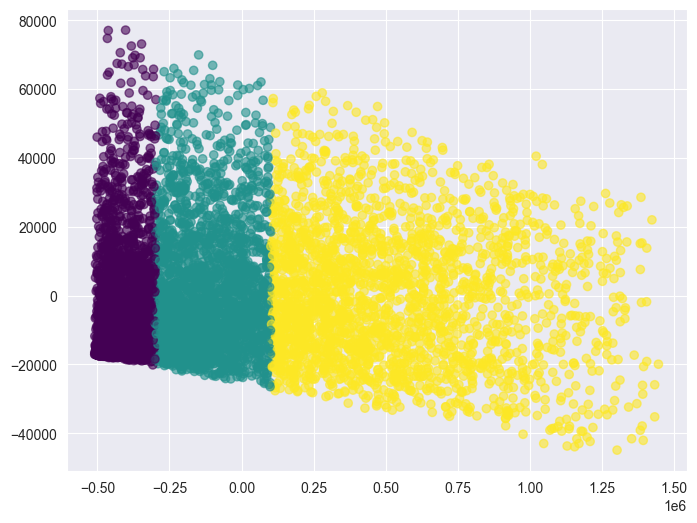

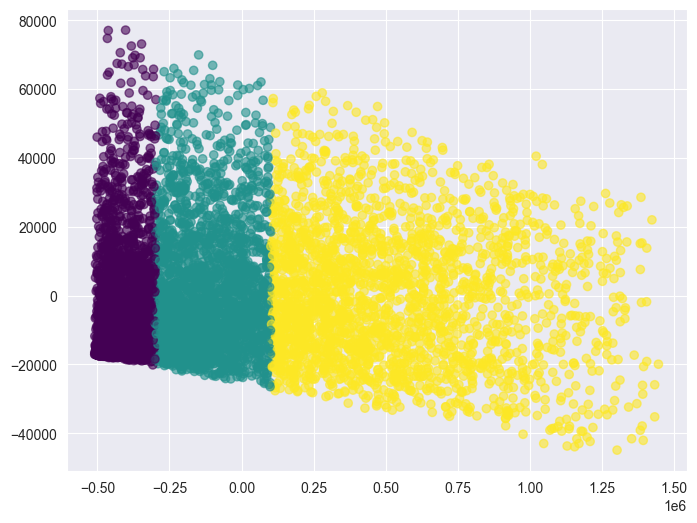

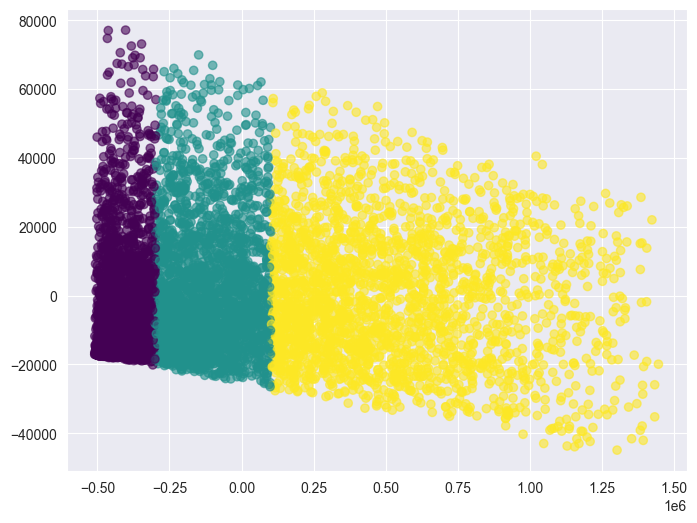

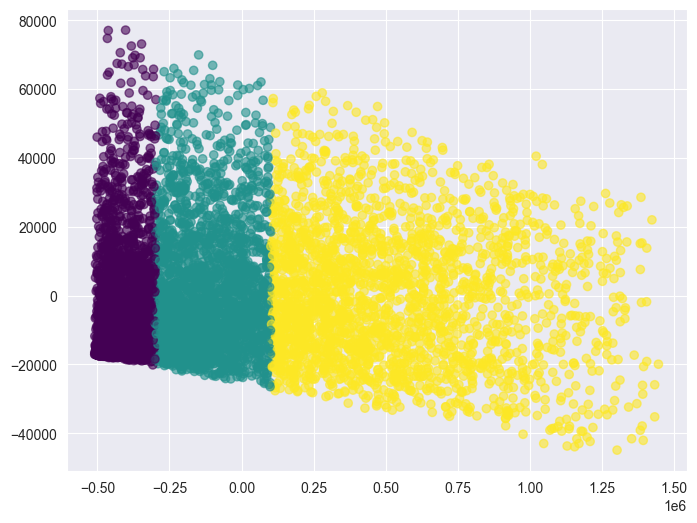

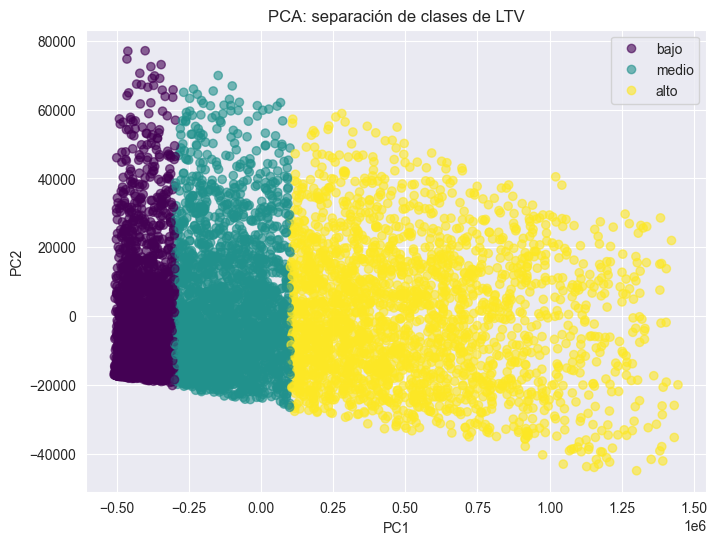

In [68]:
from sklearn.decomposition import PCA

# Variables codificadas (sin las dummies de LTV)
X_pca = df_encoded.drop(columns=[c for c in df_encoded if c.startswith('LTV_cat')])

pca = PCA(n_components=2, random_state=42)
comp = pca.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
# Guardamos el scatter para extraer los handles para la leyenda
scatter = plt.scatter(comp[:, 0], comp[:, 1], c=y_cls.cat.codes, cmap='viridis', alpha=0.6)
# Extraemos y asignamos las etiquetas
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, ['bajo', 'medio', 'alto'])
plt.title('PCA: separación de clases de LTV')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Conclusiones y Recomendaciones

**Hallazgos clave:**
- Las variables más predictivas de LTV son **Total_Transactions** y **Avg_Transaction_Value**, explicando la mayor parte de la varianza.
- La regresión lineal sin fugas obtuvo un R² ≈ 0.85, indicando un buen ajuste lineal.
- El Random Forest Regressor optimizado alcanzó un R² ≈ 0.9995 con validación cruzada, confirmando la fuerza de esas dos features.
- La clasificación en “bajo/medio/alto” con Random Forest obtuvo un F1-score ponderado ≈ 0.85, mejorando la clase media respecto a la regresión logística.

**Implicaciones de negocio:**
- Priorizar campañas de retención y upsell en clientes con alto número de transacciones y valor promedio alto.
- Desarrollar estrategias de incentivación para aumentar el promedio de transacción en clientes de valor medio.

**Siguientes pasos:**
1. Implementar la versión final del modelo en un pipeline de producción.
2. Monitorizar el desempeño con datos nuevos y recalibrar periódicamente.
3. Explorar variables adicionales (p.ej. métricas de interacción de app) para mejorar aún más la predicción.

In [70]:
# Guardar el modelo entrenado para la app
import pickle

# rf_reg es el RandomForestRegressor optimizado
with open('../model_rf.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)
print("Modelo guardado en model_rf.pkl")

Modelo guardado en model_rf.pkl
